# POC Analysis

This analysis is to determine if the pump status algorithm change on v107B has actually fixed any of the wells

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load Data

In [2]:
runtime_diff_raw = pd.read_excel('C:/Users/212340292/Desktop/POC_Runtime_Analysis.xlsx', sheetname='Runtime Difference')
runtime_diff_raw.index = runtime_diff_raw.Date
del runtime_diff_raw['Date']

In [3]:
runtime_diff_raw.head()

,3-H1,C-85,3-8,H5-6E,5-H1,6-I,1-NR,2-M,6-G2,1-D,1-G,5-J,HA-3JV,5-J1,4-H1,5-G,5-K,IHI-1H,H6-BJV
Date,,,,,,,,,,,,,,,,,,,
2017-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-06,-0.059583,NaN,0.005892,-0.428333,NaN,-0.273846,0,0.022979,-0.160088,0.101034,-0.176546,0.295556,-0.075833,-0.050000,NaN,NaN,NaN,0,-0.266667
2017-03-05,-0.080000,NaN,-0.000417,-0.469167,NaN,-0.238462,0,0.012766,-0.126667,0.096032,-0.157917,0.304444,-0.098333,-0.057917,NaN,NaN,NaN,0,-0.202500
2017-03-04,-0.059167,NaN,0.005892,-0.315417,NaN,-0.277259,0,0.025152,-0.145000,0.124111,-0.173333,0.316372,NaN,-0.041250,NaN,NaN,NaN,0,-0.254583


### Distributions

This is getting the distributions of time differences before and after the firmware upgrade, which happened from 2/20 to 2/22

In [4]:
#splits datasets into before and after fw upgrade
upgrade_after = runtime_diff_raw[:'2017-2-22']
upgrade_before = runtime_diff_raw['2017-2-19':]

In [5]:
out = pd.DataFrame(upgrade_before.median()*100,columns=['Before Mean'])
out['After Mean'] = upgrade_after.median()*100
print out

        Before Mean  After Mean
3-H1      -6.208333   -9.479167
C-85       2.864647         NaN
3-8       -2.835648   -0.041667
H5-6E     -9.041667  -50.145833
5-H1     -37.870745         NaN
6-I        0.156971  -21.990118
1-NR      -0.125000   -0.041667
2-M        1.841106    1.593389
6-G2     -23.547254  -12.333333
1-D       10.724317    9.853298
1-G      -15.796392  -17.493986
5-J       26.908023   30.454010
HA-3JV          NaN  -10.729167
5-J1     -38.000000   -6.104167
4-H1     -39.772727  -22.368421
5-G        2.248934    2.898943
5-K       -6.739440   -6.990291
IHI-1H    -0.041667    0.000000
H6-BJV   -14.375000  -16.187500


### Student t dependent test

P value less than 0.05 and the means are significantly different (there was a statistically significant change from the fw). Otherwise they're pretty much the same and we can't tell a difference

In [6]:
# Add column to out df for later use
out['pvalue'] = [np.nan for i in range(len(upgrade_after.columns))]

# loop through all wells and calculate pvalue from student t test
for idx, col in enumerate(upgrade_after.columns):

    # Fix array length
    a = upgrade_before.ix[:len(upgrade_after),idx].dropna()
    b = upgrade_after.ix[:,idx].dropna()

    if len(a) > len(b):
        a = a.ix[:len(b)]
    elif len(b) > len(a):
        b = b.ix[:len(a)]

    # If no useable data points avaliable for the test
    if len(a) == 0:
        print col + ' is not evaluated'
        continue
    else:
        stat, pval = stats.ttest_rel(a, b)
        
        out['pvalue'][col] = pval
        
        #if pval < 0.05:
        print col + ' pval: %0.2f tstat: %2.2f' % (pval, stat)

3-H1 pval: 0.90 tstat: -0.13
C-85 is not evaluated
3-8 pval: 0.35 tstat: -1.00
H5-6E pval: 0.00 tstat: 5.13
5-H1 is not evaluated
6-I pval: 0.00 tstat: 7.47
1-NR pval: 0.98 tstat: -0.03
2-M pval: 0.28 tstat: 1.17
6-G2 pval: 0.01 tstat: -3.64
1-D pval: 0.95 tstat: 0.06
1-G pval: 0.13 tstat: 1.72
5-J pval: 0.00 tstat: -7.48
HA-3JV is not evaluated
5-J1 pval: 0.00 tstat: -5.58
4-H1 pval: 0.15 tstat: -1.78
5-G pval: 0.49 tstat: 0.74
5-K pval: 0.32 tstat: -1.32
IHI-1H pval: 0.33 tstat: -1.04
H6-BJV pval: 0.72 tstat: 0.38


### Density Estimate

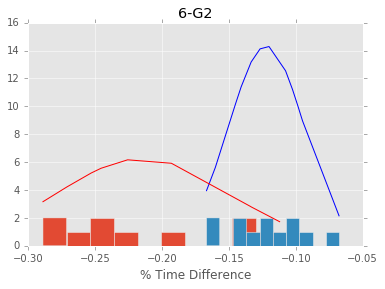

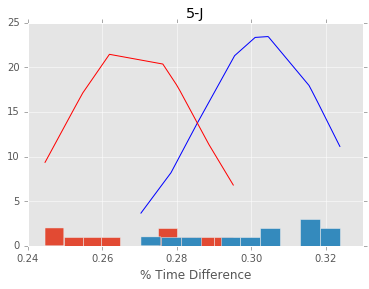

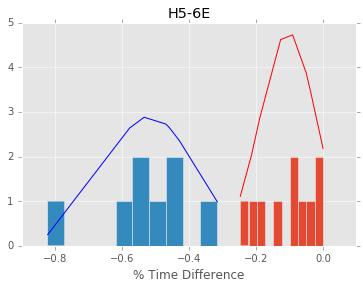

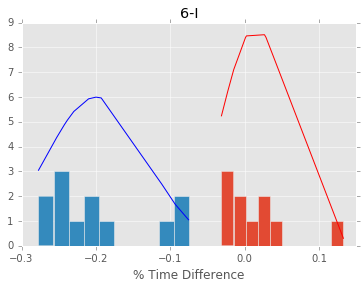

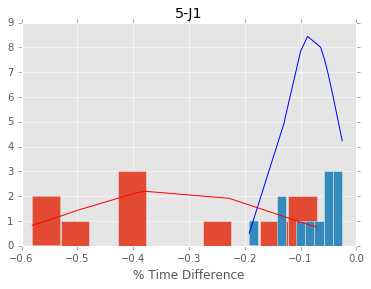

In [7]:
# Loop through and plot density estimate for wells with a pvalue less than 0.05
for val, col in enumerate(upgrade_after.columns):

    if out['pvalue'][col] < 0.05:
    
        plt.figure(val)

        h = upgrade_after.ix[:,val]
        h = h.sort_values()
        fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
        plt.plot(h,fit, color='blue')
        
        upgrade_before.ix[:,val].hist()
        upgrade_after.ix[:,val].hist()

        h = upgrade_before.ix[:,val]
        h = h.sort_values()
        fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

        plt.plot(h,fit, color='red')
        plt.title(col)
        plt.xlabel("% Time Difference")


### Final significant pvalues

In [8]:
out[out['pvalue']<0.05]

,Before Mean,After Mean,pvalue
H5-6E,-9.041667,-50.145833,0.001349
6-I,0.156971,-21.990118,0.000140
6-G2,-23.547254,-12.333333,0.008341
5-J,26.908023,30.454010,0.000140
5-J1,-38.000000,-6.104167,0.000835


### Conclusion

There are four wells that have a significant difference in means according the student t test.  Which would mean that the firmware change had a significant impact on the pump status algorithm.  **_However_**, looking at the mean values of the significant tests show no discernable difference (positive or negative) in the means.  Thus, it can be concluded that this firmware change had no impact, either positive or negative.